#### Загрузка набора данных

In [34]:
import pandas

test_data = pandas.read_csv('data/test.csv')
training_data = pandas.read_csv('data/training.csv')
validation_data = pandas.read_csv('data/validation.csv')

print(test_data.info())
print(training_data.info())
print(validation_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2000 non-null   object
 1   label   2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16000 non-null  object
 1   label   16000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 250.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2000 non-null   object
 1   label   2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB
None


#### Подготовка набора данных

In [36]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

lemmatizer = WordNetLemmatizer()

def prepare_text(text):
    text = text.lower()

    stop_words = set(stopwords.words('english'))
    
    # Удаление небуквенных символов и приведение к нижнему регистру
    text = ''.join(character for character in text if character.isalpha() or character.isspace())

    # Лемматизация
    tokens = [lemmatizer.lemmatize(word) for word in text.split()]

    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]

    text = ' '.join(tokens)
    
    return text

test_data['text'] = test_data['text'].apply(prepare_text)
training_data['text'] = training_data['text'].apply(prepare_text)
validation_data['text'] = validation_data['text'].apply(prepare_text)

print(test_data)
print(training_data)
print(validation_data)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Aleksei\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Aleksei\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aleksei\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                                   text  label
0           im feeling rather rotten im ambitious right      0
1                          im updating blog feel shitty      0
2       never make separate ever want feel like ashamed      0
3     left bouquet red yellow tulip arm feeling slig...      1
4                            wa feeling little vain one      0
...                                                 ...    ...
1995  keep feeling like someone unkind wrong think g...      3
1996  im feeling little cranky negative doctor appoi...      3
1997  feel useful people give great feeling achievement      1
1998  im feeling comfortable derby feel though start...      1
1999  feel weird meet w people text like dont talk f...      4

[2000 rows x 2 columns]
                                                    text  label
0                                  didnt feel humiliated      0
1      go feeling hopeless damned hopeful around some...      0
2              im grabbing 

#### Построение частотного словаря

In [38]:
import collections

test_data_words = []

for _, row in test_data.iterrows():
    test_data_words.extend(row['text'].split())

test_data_dictionary = dict(collections.Counter(test_data_words))

test_data_dictionary = dict(sorted(test_data_dictionary.items(), key=lambda item: item[1], reverse=True))

print(list(test_data_dictionary.items())[:10])

[('feel', 1441), ('feeling', 688), ('like', 374), ('im', 310), ('wa', 297), ('really', 118), ('time', 116), ('know', 105), ('get', 103), ('people', 99)]


#### Визуализация

C:\Users\Aleksei\AppData\Local\Temp\ipykernel_15836\1936840171.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)


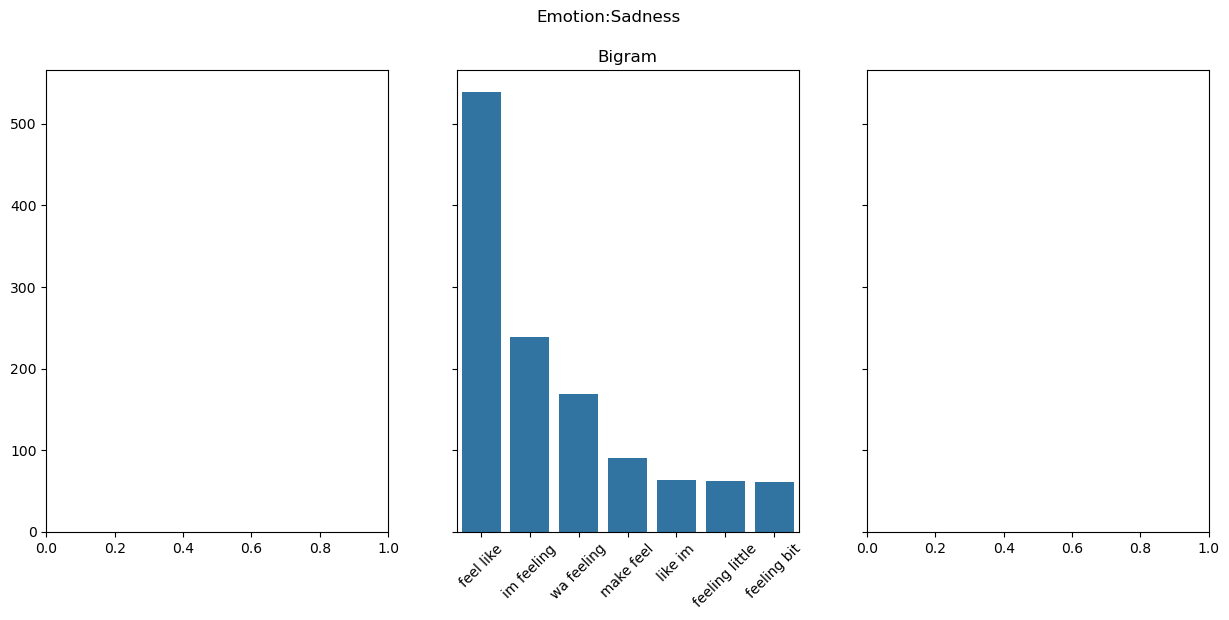

C:\Users\Aleksei\AppData\Local\Temp\ipykernel_15836\1936840171.py:51: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(training_data['tweet_length'])


(0.0, 500.0)

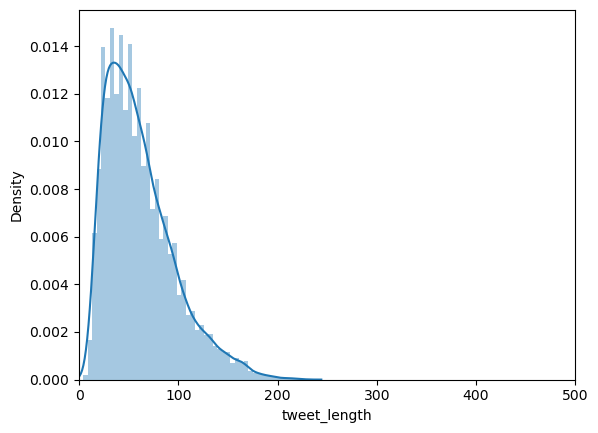

In [97]:
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt
import seaborn as sns

sadness = training_data[training_data['label']==0]['text']
anger = training_data[training_data['label']==1]['text']
love = training_data[training_data['label']==2]['text']
surprise = training_data[training_data['label']==3]['text']
fear = training_data[training_data['label']==4]['text']
joy = training_data[training_data['label']==5]['text']

def get_top_n_gram(corpus,ngram_range,n=None):
    Vectorizer = CountVectorizer(ngram_range = ngram_range, stop_words ='english')
    vec = Vectorizer.fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return dict(words_freq[:n])

sadness_bi = get_top_n_gram(sadness,(2,2),7)
anger_bi = get_top_n_gram(anger,(2,2),7)
love_bi = get_top_n_gram(love,(2,2),7)
surprise_bi = get_top_n_gram(surprise,(2,2),7)
fear_bi = get_top_n_gram(fear,(2,2),7)
joy_bi = get_top_n_gram(joy,(2,2),7)

fig,axes = plt.subplots(1,3,figsize=(15, 6), sharey=True)
fig.suptitle("Биграммы")

sns.barplot(x = list(sadness_bi.keys()) ,y=list(sadness_bi.values()),ax=axes[1])
axes[1].set_title("Биграммы")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

plt.show()

training_data['tweet_length'] = training_data['text'].astype('str').apply(len) 

training_data['word_count'] = training_data['text'].apply(lambda x:len(str(x).split()))

sns.distplot(training_data['tweet_length'])
plt.xlim([0,500])

#### Распределение меток по классам

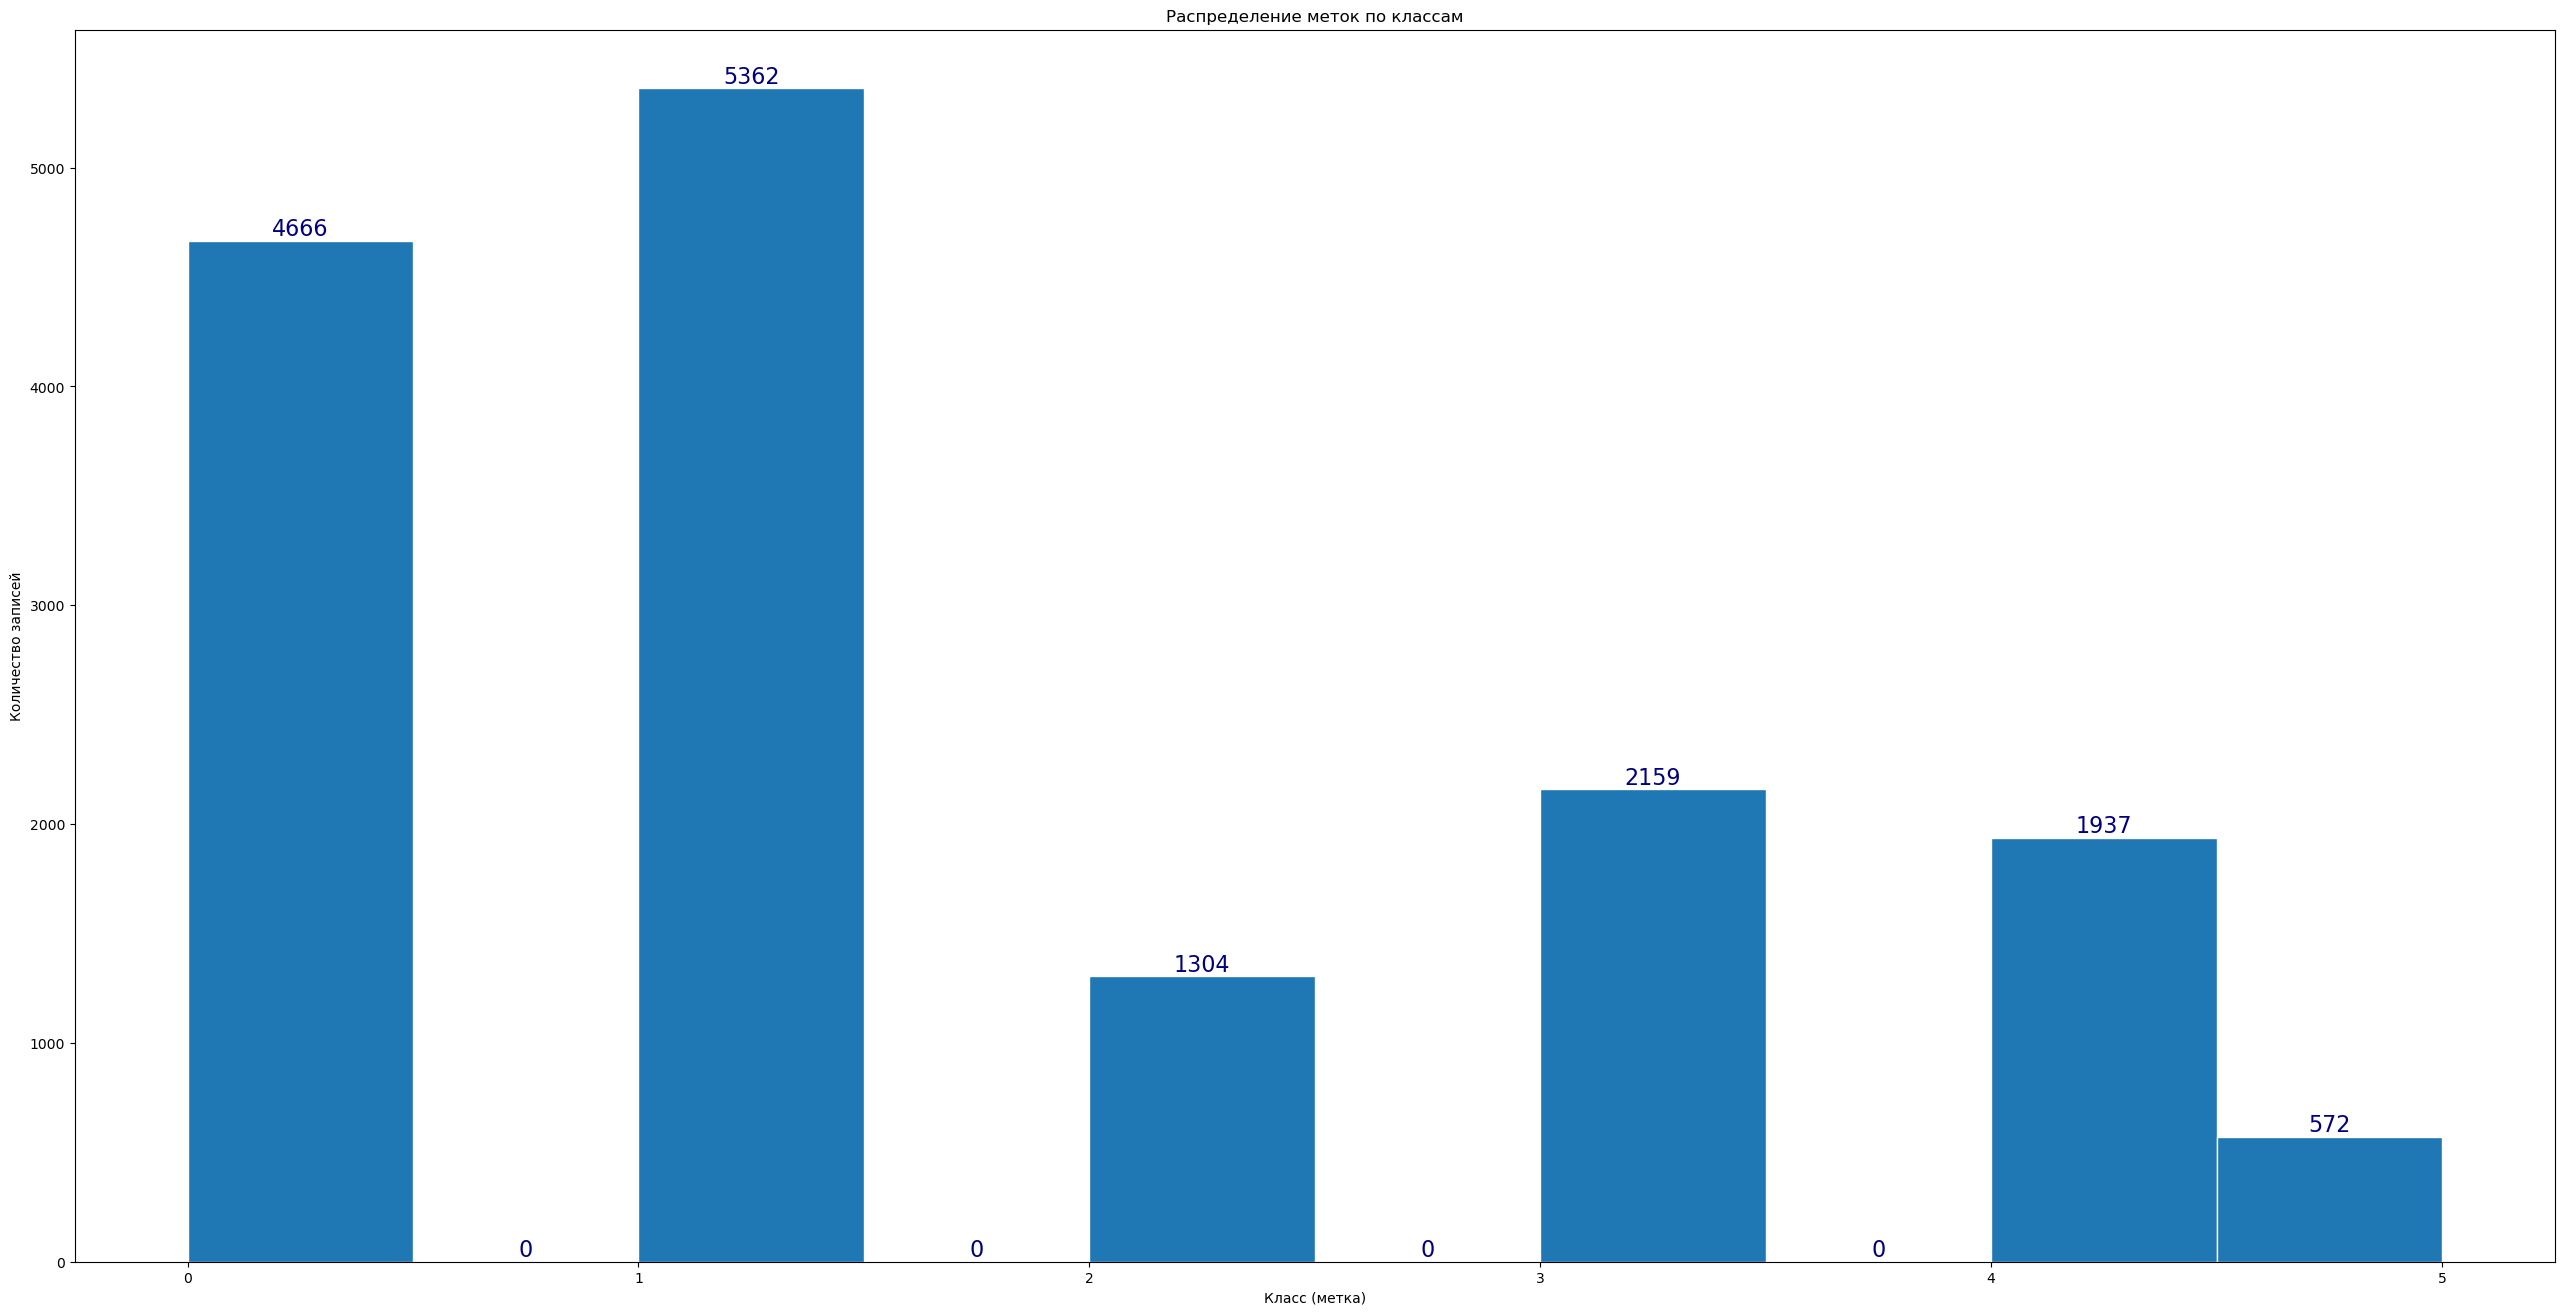

In [42]:
from matplotlib import pyplot as plot

plot.figure(figsize=(32, 16))

values, bins, bars = plot.hist(training_data['label'], edgecolor='white')

plot.xlabel("Класс (метка)")
plot.ylabel("Количество записей")

plot.title('Распределение меток по классам')

plot.bar_label(bars, fontsize=16, color='navy')

plot.show()

#### Подбор оптимальных параметров и тренировка модели

In [44]:
import numpy
import pandas

from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adagrad
import tensorflow
documents = training_data['text']

vectorizer = TfidfVectorizer(max_features=4096)

tfidf_matrix = vectorizer.fit_transform(documents)

X_validation = vectorizer.transform(validation_data['text'])

vectors = tfidf_matrix.toarray()

N = vectors.shape[0]
L = vectors.shape[1]
C = 1

X_training = vectors.reshape(N, L, C)

y = numpy.array(training_data['label'])

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y = label_encoder.fit_transform(y)

model = Sequential()

model.add(Conv1D(filters=12, kernel_size=4, activation='relu', input_shape=(L, C)))
model.add(Conv1D(filters=6, kernel_size=2, activation='relu', input_shape=(L, C)))
model.add(Conv1D(filters=4, kernel_size=3, activation='relu', input_shape=(L, C)))

model.add(MaxPooling1D(pool_size=4))

model.add(Flatten())

model.add(Dense(6, activation='relu'))

model.add(Dense(len(label_encoder.classes_), activation='softmax', kernel_regularizer=l2(0.01)))

tensorflow.keras.utils.plot_model(model, show_shapes=True)

model.compile(optimizer=Adagrad(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_training, y, epochs=30, validation_data=(X_validation, numpy.array(validation_data['label'])))

You must install pydot (`pip install pydot`) for `plot_model` to work.


C:\Users\Aleksei\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 34s 64ms/step - accuracy: 0.3277 - loss: 1.7395 - val_accuracy: 0.3520 - val_loss: 1.6181
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 30s 59ms/step - accuracy: 0.3280 - loss: 1.6188 - val_accuracy: 0.3520 - val_loss: 1.6044
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 29s 58ms/step - accuracy: 0.3354 - loss: 1.6036 - val_accuracy: 0.3520 - val_loss: 1.6002
Epoch 4/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 29s 57ms/step - accuracy: 0.3335 - loss: 1.5941 - val_accuracy: 0.3520 - val_loss: 1.5957
Epoch 5/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 28s 56ms/step - accuracy: 0.3361 - loss: 1.5889 - val_accuracy: 0.3520 - val_loss: 1.5938
Epoch 6/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 28s 55ms/step - accuracy: 0.3356 - loss: 1.5874 - val_accuracy: 0.3520 - val_loss: 1.5929
Epoch 7/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 30s 59ms/step - accuracy: 0.3305 - loss: 1.5926 - val_accuracy: 0.3520 - val_loss: 1.5914
Epoch 8/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 30s 60ms/step - accuracy: 0.3346 - loss: 1.5846 - 

#### Графики тренировки модели

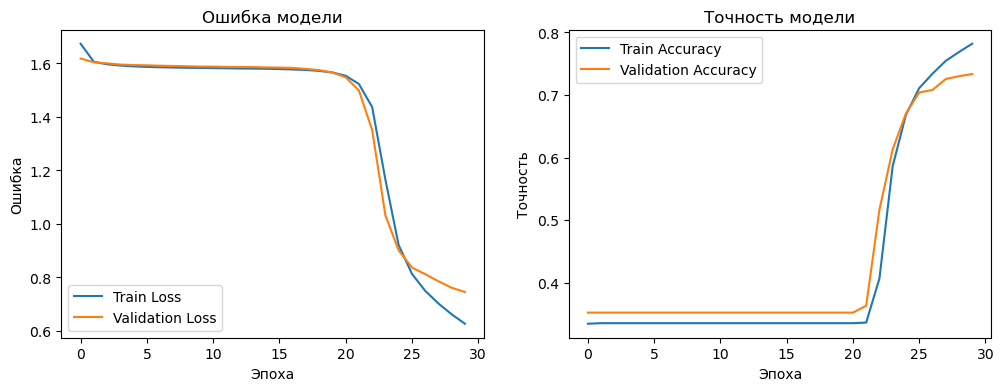

In [46]:
import matplotlib.pyplot as plot

plot.figure(figsize=(12, 4))

plot.subplot(1, 2, 1)

plot.plot(history.history['loss'], label='Train Loss')
plot.plot(history.history['val_loss'], label='Validation Loss')

plot.title('Ошибка модели')

plot.ylabel('Ошибка')
plot.xlabel('Эпоха')

plot.legend()

plot.subplot(1, 2, 2)

plot.plot(history.history['accuracy'], label='Train Accuracy')
plot.plot(history.history['val_accuracy'], label='Validation Accuracy')

plot.title('Точность модели')

plot.ylabel('Точность')
plot.xlabel('Эпоха')

plot.legend()

plot.show()

#### Проверка модели на тестовых данных

In [70]:
import numpy

tfidf_matrix = vectorizer.fit_transform(documents)

X_test = vectorizer.transform(test_data['text'])

y = numpy.array(test_data['label'])

model.summary()

loss, accuracy = model.evaluate(X_test, y)

print(f'Потери: {loss}, Точность: {accuracy}')

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)                    │ (None, 4093, 12)            │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 4092, 6)             │             150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 4090, 4)             │              76 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 1022, 4)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 4088)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 6)                   │          24,534 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │              42 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,726 (194.25 KB)

 Trainable params: 24,862 (97.12 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 24,864 (97.13 KB)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7211 - loss: 0.7759
Потери: 0.76094651222229, Точность: 0.7294999957084656


#### Матрица ошибок

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


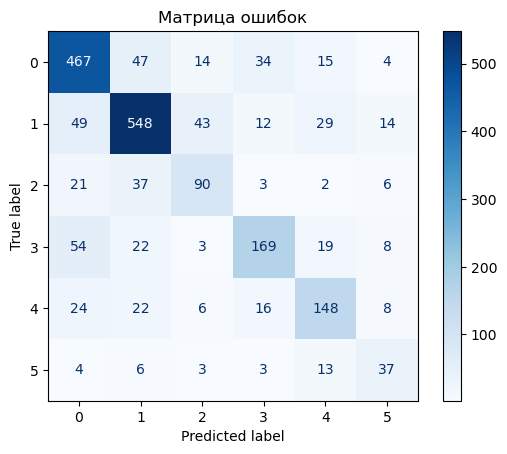

In [60]:
import matplotlib.pyplot as plot

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_actual = test_data['label'][:2000]
y_predicted = [list(l).index(max(list(l))) for l in model.predict(X_test[:2000])]

matrix = confusion_matrix(y_actual, y_predicted)

display = ConfusionMatrixDisplay(confusion_matrix=matrix)

display.plot(cmap=plot.cm.Blues)

plot.title('Матрица ошибок')

plot.show()

In [72]:
tfidf_matrix = vectorizer.fit_transform(documents)

texts = [
    'just for fun',
    'wa the hell is that',
    'surrounding me as fear consumes my soul'
]

example_data = vectorizer.transform(texts)

print(model.predict(example_data))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
[[0.08280979 0.14736861 0.05540354 0.12855168 0.03409939 0.5517669 ]
 [0.32882136 0.04913744 0.00623255 0.32164901 0.29061925 0.00354038]
 [0.11197504 0.2315237  0.02084313 0.04166875 0.5900554  0.00393399]]


#### Precision, Recall, F1

In [91]:
from sklearn.metrics import classification_report

In [93]:
report = classification_report(y_actual, y_predicted)

print(report)

              precision    recall  f1-score   support

           0       0.75      0.80      0.78       581
           1       0.80      0.79      0.80       695
           2       0.57      0.57      0.57       159
           3       0.71      0.61      0.66       275
           4       0.65      0.66      0.66       224
           5       0.48      0.56      0.52        66

    accuracy                           0.73      2000
   macro avg       0.66      0.67      0.66      2000
weighted avg       0.73      0.73      0.73      2000

